## Introduction
The file `data_AEX_FTSE.xlsx` contains daily log returns of the AEX and FTSE index returns for the period 5 January 2000 - 12 March 2020. The log return of asset $i$ on day $t$ is defined as $R_{i,t} = 100 \cdot \log(\frac{S_{i,t}}{S_{i,t-1}})$, with $S_{i,t}$ the price of asset $i$ on date $t$.

 In this assignment you are asked to calculate multi-period Value-at-Risk forecasts through Monte Carlo simulation (MCS). First, we obtain the VaR for the AEX index. Subsequently, we employ copula methods to obtain the VaR for a portfolio of two assets.

## Question 1: Load, clean, and model data [20 pts.]
First, install and import the relevant libraries:

In [10]:
# !pip install arch             
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

Import the data in a DataFrame. The data is already transformed using methods that were used in Assignment 1 as well. Uncomment and adapt the lines necessary to mount the drive and change the path.

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/...'    # change path to your working directory
# os.chdir(path)

df = pd.read_excel('data_AEX_FTSE.xlsx') 
df = df.set_index(['Date']) # set 'Date' column as index

R_AEX = df['R_AEX']
R_FTSE = df['R_FTSE']

df.tail()

,R_AEX,R_FTSE
Date,,
2020-03-06,-3.967831,-3.689551
2020-03-09,-8.074168,-7.668863
2020-03-10,-1.059273,-0.240360
2020-03-11,-0.586694,-1.932034
2020-03-12,-10.638548,-10.136507


Suppose you are a risk manager and it is currently just after closing time of the trading day 12 March 2020, i.e. we are at the end of period $t=T$, with $T$ indicating 12 March 2020. You are asked to calculate the 10-day VaR on the AEX index, i.e. $VaR^p_{T+1:T+K}$, with horizon $K=10$ trading days. After some thought you decide to model the index with a GARCH model, and use Monte Carlo Simulation to obtain the 10-day VaR.

Estimate a GARCH(1,1) model, with constant mean return and standardized $t$ distributed shocks, for the AEX index returns. 

Plot the volatility series and analyze the shocks. Also obtain the one-day-ahead volatility forecast for 13 March 2021. Discuss your results. Can you attribute certain economic events to your observations for 12 March 2020?

Notes: 

* By specifying `dist = ` in the `arch_model` function we can change the distribution of the shocks. See the documentation at https://arch.readthedocs.io.
* GARCH model residuals can be obtain from the `.resid` attribute belonging to the fitted model (which is generated by the `.fit()` method). Conditional volatilities can be obtained similarly from the `.conditional_volatility` attribute. 
* The 1-day conditional variance forecast (note: variance instead of volatility) can be obtained as `x.forecast().variance['h.1']['2020-03-12']`, where `x` is the fitted model object, and the dates index refers to the date the forecast is made (so here we generate a forecast at the end of 12 March and forecast one-day ahead for the date 13 March.)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


21.06979046661523

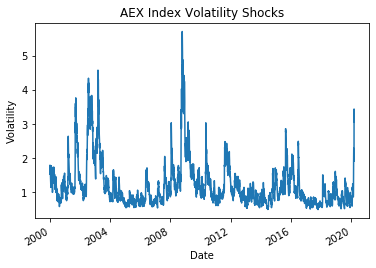

In [12]:
am = arch_model(R_AEX, vol='GARCH',p=1,o=0,q=1,dist='studentst') #GARCH(1,1) model with constant mean return + standadized t dist
fitted_model = am.fit()
residuals= fitted_model.resid #GARCH model residuals
conditional_vol=fitted_model.conditional_volatility #Conditional volatilities of GARCH model

conditional_vol.plot() #Plotting volatility series
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('AEX Index Volatility Shocks')

fitted_model.forecast().variance['h.1']['2020-03-12'] #1-day conditional variance forecast

Discussion of results: Upon analyzing the plotted volatility series, the graph illustrates shocks that can be easily  explained by historical events which had an evident effect on the AEX index returns. Around 2002-2003, there appears to be some volatility shocks, which can be explained by the 2002 market downturn that led to dramatic slides in stock indices (and thus schocks to the volatility series). Around 2008, the most pronounced volatility shock is captured by the 2008 Financial Crisis (causde by subprime loans and credit default swaps). In 2020, there also appears to be a volatility shock, which can be explained by the COVID-19 crisis and its subsequent effect on the world financial markets. Furthermore, on the 12th March 2020, an event known as Black Thursday lead to huge volatility shocks as the US stock market suffered the greatest-single day percentage fall since the 1987 stock market crash (to note, this event is a part of the greater 2020 stock market crash caused by COVID-19).

Finally, the one-day ahead variance forecast for March 13,2020 is approximately 21.0697, which is a volatilty value of around 4.59. This is quite an increase from the volatility value of March 12,2020 (which is just under 4) but this can be explained by the markets pricing in the information of Black Thursday (as well as the increase in volatility prior to the event) and the rapid volatility shock that ensued. 

## Question 2: Monte Carlo Simulation of 10-day ahead VaR [25 pts.]
We use Monte Carlo simulation to obtain the 10-day ahead Value-at-Risk forecast at $p=0.01$, 10-days ahead of 12 March 2020. 

A 'code skeleton' is included below, which you should complete. Implement steps A to F:

* A: Replace `x` with the fitted GARCH model object generated by the `.fit()` method in the previous question.
* B: For date $T+k$, $k=1$ we know the conditional variance forecast. Replace `xx` with the value you obtained for 13 March 2020 in the previous question.
* C: For dates $T+k$, $k > 1$ we use the GARCH model specification. Replace `xxx` with the GARCH equation: $\sigma_{T+k}^2 = \omega + \alpha (\sigma_{T+k-1} z_{T+k-1})^2 + \beta \sigma_{T+k-1}^2$, using your estimated parameters (see Step A).
* D: Replace `xxxx` with the proper definition of the K-day holding return.
* E: Obtain the K-day Value-at-Risk forecast using the sample percentile: $VaR^p_{T+1:T+K} = -Percentile\bigl\{\{\check{R}_{i,T+1:T+K}\}_{i=1}^{MC},100p\bigr\}$, with $\{\check{R}_{i,T+1:T+K}\}_{i=1}^{MC}$ the simulated $K$-day returns. (Hint: use the `numpy` function `np.percentile`.)

Plot the histogram of $\{\check{R}_{i,T+1:T+K}\}_{i=1}^{MC}$, and estimate the skewness and excess kurtosis of the sample. Compare the MCS estimate of the 10-day VaR, with the 'square-root rule' VaR, $\sqrt{K} \, VaR^p_{T+1}$. Discuss your results. Can you give a reason why you find the specific ranking of VaR values?


In [13]:
MC = 10000 # amount of Monte Carlo replications
VaR_level = 0.01 # the Value-at-Risk parameter `p`

K= 10 # The parameter K determins the length of the holding period, so we obtain a K-day return

# Obtain the GARCH parameters from `x`, the fitted model object generated by the .fit() method in the previous question
#---! STEP A:
[mu,omega,alpha,beta,d1] = fitted_model.params

# initialize a (MC x 1) vector to store the cumulative returns generated in the MC Monte Carlo replications
sim_cumulative_returns = np.zeros([MC,1])

# simulate the shocks 
sim_shocks = np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=[K,MC]) 

for i in range(MC): # we enter the `for loop' of Monte Carlo replications. In each iteration we compute a 10-day ahead return
    
    # initialize a (K x 1) return vector which will be filled with simulated returns for dates t+1,...,t+K (the vector is refreshed every Monte Carlo iteration)
    sim_returns = np.zeros([K,1])
    
    # initialize a (K x 1) conditional variance vector (the vector is refreshed every Monte Carlo iteration)
    sim_condvariance = np.zeros([K,1])
    
    for k in range(K): # we now generate K consecutive returns by iterating the volatility process, and utilizing the random shock draws
        
        if k == 0: # note that Python indexes the first element in a loop or vector as '0'
            # on the first day of the holding period we can use the 1-day ahead GARCH volatility forecast
            #---! STEP B:
            sim_condvariance[k] = fitted_model.forecast().variance['h.1']['2020-03-12']
        elif k > 0: # for further days in the future we use the garch equation putting in the simulated shocks
            #---! STEP C:
            sim_condvariance[k] = omega + alpha * (np.sqrt(sim_condvariance[k-1]) * sim_shocks[k-1,i])**2 + beta * sim_condvariance[k-1]
        
        # calculate and save the simulated return
        sim_returns[k] = mu + np.sqrt(sim_condvariance[k]) * sim_shocks[k,i];    
        
    # estimate cumulative holding period return and save it as element 'i' in the (MC x 1) vector of sim_cumulative_returns
    #---! STEP D: 
    sim_cumulative_returns[i] = sum(sim_returns)
            
# now we have simulated the cumulative returns for each of our Monte Carlo iterations we can estimate the Value-at-Risk using the sample percentile function
#---! Step E:
VaR = -np.percentile(sim_cumulative_returns, 100 * VaR_level)


skewness:  [0.00726761]
kurtosis:  [1.72965838]
the MCS estimate of the 10-day VaR:  35.79029033046534
The square-root rule Var :  113.17883556297092


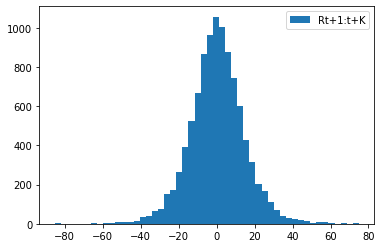

In [14]:
from scipy.stats import skew, kurtosis

# Skewness & kurtosis
sk = skew(sim_cumulative_returns, bias= False)
kt = kurtosis(sim_cumulative_returns, bias= False)
print('skewness: ', sk)
print('kurtosis: ', kt)

# 'square-root rule' VaR
sq_VaR = (np.sqrt(K))*VaR

print('the MCS estimate of the 10-day VaR: ', VaR)
print('The square-root rule Var : ', sq_VaR)

# Plot
plt.hist(sim_cumulative_returns, bins = 50)
plt.legend(['Rt+1:t+K'])
plt.show()


Discussion of results: 

In advance, VaR should be positive number. Thus, the MCS estimate of the 10-day VaR is 35.64. Then the 'square-root rule' VaR is 112.69. The MCS estimate of the 10-day VaR is smaller than the 'square-root rule' VaR. Finding the specific ranking of VaR values is important because the VaR estimates the extent of possible financial losses within a portfolio. Therefore, the VaR should be as small as possible. This is the reason why we find the specific ranking of VaR values. In this case, the 'square-root rule' VaR is worse than the MCS estimate of the 10-day VaR.

## Question 3: Copula [15 pts.]

Suppose we have estimated another GARCH model for the FTSE index returns. Once we have the shocks of both assets, we estimate a bivariate normal copula model, and find an estimate for the copula correlation parameter, $\hat{\rho} = 0.80$. We want to simulate standardized $t$-shocks for the AEX and FTSE index returns, with the dependence between shocks modelled by this normal copula.

Below we have included code that performs simulation from the normal copula. 

Explain in detail what steps A to D achieve. Also explain how the scatter plot created at the end of the code shows the difference in correlation between the two sets of shocks, as well as the difference in fat-tailedness.



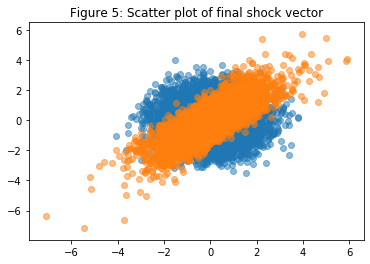

In [15]:
# simulate the copula shocks
copula_corr = 0.80 # the parameter rho
d_1 = d1; # degrees of freedom parameter for standardized t distribition of AEX shock 
d_2 = d1; # degrees of freedom parameter for standardized t distribition of FTSE shock

#---! STEP A:
sim_uncorrelated_normal_shocks = stats.norm.rvs(size=[K,MC,2]) # result is a (K x MC x 2) array

#---! STEP B:
sim_correlated_normal_shocks = np.zeros([K,MC,2])
sim_correlated_normal_shocks[:,:,0] = sim_uncorrelated_normal_shocks[:,:,0]
sim_correlated_normal_shocks[:,:,1] = copula_corr * sim_uncorrelated_normal_shocks[:,:,0] + np.sqrt(1 - copula_corr**2) * sim_uncorrelated_normal_shocks[:,:,1] 

#---! STEP C:
sim_normal_copula_shocks = stats.norm.cdf(sim_correlated_normal_shocks)

#---! STEP D: 
sim_new_shocks = np.zeros([K,MC,2])
sim_new_shocks[:,:,0] = np.sqrt((d_1 - 2) / d_1) * stats.t.ppf(sim_normal_copula_shocks[:,:,0],d_1) 
sim_new_shocks[:,:,1] = np.sqrt((d_2 - 2) / d_2) * stats.t.ppf(sim_normal_copula_shocks[:,:,1],d_2) 

# create a scatter plot for MC shock vector draws
plt.title('Figure 4: Scatter plot of uncorrelated normal vector draws')
plt.scatter(sim_uncorrelated_normal_shocks[1,:,0], sim_uncorrelated_normal_shocks[1,:,1], alpha=0.5)

plt.title('Figure 5: Scatter plot of final shock vector')
plt.scatter(sim_new_shocks[1,:,0], sim_new_shocks[1,:,1], alpha=0.5)

Discussion of results:

A copula is joint distribution of two random variables with uniform marginal distribution. Furthermore, copula is a statistical method for understanding the joint probabilities of a multivariate distribution. Nowadays, copula is utilized in advanced financial analysis to better understand outcomes that involve excess kurtosis and skewness.

Step A:

The first step is to simulate uncorrelated normal shock using the Scipy normal function with random variables. Random variables are uncorrelated with each other. Thus, the function "stats.norm.rvs(size=[K,MC,2])" is suitable for simulating uncorrelated normal shock. 


Step B: 

The second step is to set two random variables using Monte Carlo Simulation (MCS). MCS is with constant correlation 0.8. Here sim_uncorrelated_normal_shocks[:,:,0] and sim_uncorrelated_normal_shocks[:,:,1] are two independent N(0,1) random variables, which is based on Cholesky decomposition of correlation matrix. In other words, this step calculates the joint probabiliteis of two random variabels with the copular correlation because the copula is desinged to understand the joint probabilities of a multivariate distribution . 


Step C: 

According to Sklar's theorem, a copular cumulative distribution function (CDF) exists for every joint distribution. 
THus, the copula approach builds a bivariate CDF. In consequence, we simulate the copular CDF using the function "stats.norm.cdf(sim_correlated_normal_shocks)". 


Step D: 

We calculate the value of percentage point function (PPF) which is the inverser of CDF using np.zeros and Monte Carlo Simulation. Then simulate the new normal shock. 

Scatter Plot:

Figure 4 (blue one) shows the uncorrelated normal shock, while figure 5 (orange one) shows the final shock vector which is affected by Student's t copula. The final shock vector indicates the skewed t copula.   

The uncorrelated normal vector has almost no fat tail (excess kurtosis) and skewness. However, on the other hand, the final shock vectos has fat tail (excess kurtosis) and skewness. If the copula correlation increases, the scatter plot shows linearity form. On the other hand, if the copula correlation decreases, the scatter plot shows almost circle form. Therefore, the uncorrelated normal shock shown in the figure 4 has copula correlation close to zero, while the final vector shown in the figure 5 has a higher copula correlation close to 1. 


## Question 4: MCS of an equal-weighted portfolio return [ 10 pts.]

Adapt your MCS with the simulation scheme for the copula shocks above to obtain 10-day VaR forecasts for an equal-weighted portfolio in the AEX and FTSE indices, i.e. we create a portfolio of both assets with portfolio weights $w_1=w_2=0.5$. To circumvent further estimation, you may assume that the GARCH model parameters (including the degrees of freedom) for the AEX and FTSE returns are equal, that the conditional volatility $\sigma_{t+1}$ is equal between assets, and take copula parameter $\rho = 0.8$. 

How do your VaR estimates change when $\rho$ is decreased? Given what you know of log returns and simple returns, how would you compute the simple portfolio returns `sim_cumulative_returns[i]` if our index returns, `R_AEX` and `R_FTSE`, are log returns?

In [16]:
lst_sim_new_shocks = []
lst_copular_corr = list(np.arange(-1, 1, 0.1))

for copula_corr in lst_copular_corr:  # the parameter rho

    d_1 = d1; # degrees of freedom parameter for standardized t distribition of AEX shock 
    d_2 = d1; # degrees of freedom parameter for standardized t distribition of FTSE shock

    #---! STEP A:
    sim_uncorrelated_normal_shocks = stats.norm.rvs(size=[K,MC,2]) # result is a (K x MC x 2) array

    #---! STEP B:
    sim_correlated_normal_shocks = np.zeros([K,MC,2])
    sim_correlated_normal_shocks[:,:,0] = sim_uncorrelated_normal_shocks[:,:,0]
    sim_correlated_normal_shocks[:,:,1] = copula_corr * sim_uncorrelated_normal_shocks[:,:,0] + np.sqrt(1 - copula_corr**2) * sim_uncorrelated_normal_shocks[:,:,1] 

    #---! STEP C:
    sim_normal_copula_shocks = stats.norm.cdf(sim_correlated_normal_shocks)

    #---! STEP D: 
    sim_new_shocks = np.zeros([K,MC,2])
    sim_new_shocks[:,:,0] = np.sqrt((d_1 - 2) / d_1) * stats.t.ppf(sim_normal_copula_shocks[:,:,0],d_1) 
    sim_new_shocks[:,:,1] = np.sqrt((d_2 - 2) / d_2) * stats.t.ppf(sim_normal_copula_shocks[:,:,1],d_2) 
    
    # Append sim_new shocks
    lst_sim_new_shocks.append(sim_new_shocks)


In [17]:
lst_index_VaR_weighted = []
lst_sim_cumulative_returns = []

for sim_new_shocks in lst_sim_new_shocks:
    for index in range(2):  
        log_index_ret = [R_AEX, R_FTSE]

        # Creat empty list to store VaR values
        lst_index_VaR_tmp = []

        am = arch_model(log_index_ret[0], vol='GARCH',p=1,o=0,q=1,dist='studentst') #GARCH(1,1) model with constant mean return + standadized t dist
        
        fitted_model = am.fit()
        residuals= fitted_model.resid #GARCH model residuals
        conditional_vol=fitted_model.conditional_volatility #Conditional volatilities of GARCH model

        MC = 10000 # amount of Monte Carlo replications
        VaR_level = 0.01 # the Value-at-Risk parameter `p`

        K= 10 # The parameter K determins the length of the holding period, so we obtain a K-day return

        # Obtain the GARCH parameters from `x`, the fitted model object generated by the .fit() method in the previous question
        #---! STEP A:
        [mu,omega,alpha,beta,d1] = fitted_model.params

        # initialize a (MC x 1) vector to store the cumulative returns generated in the MC Monte Carlo replications
        sim_cumulative_returns = np.zeros([MC,1])

        # Simulated shocks
        sim_shocks = sim_new_shocks[:,:,index]

        for i in range(MC): # we enter the `for loop' of Monte Carlo replications. In each iteration we compute a 10-day ahead return
            
            # initialize a (K x 1) return vector which will be filled with simulated returns for dates t+1,...,t+K (the vector is refreshed every Monte Carlo iteration)
            sim_returns = np.zeros([K,1])
            
            # initialize a (K x 1) conditional variance vector (the vector is refreshed every Monte Carlo iteration)
            sim_condvariance = np.zeros([K,1])
            
            for k in range(K): # we now generate K consecutive returns by iterating the volatility process, and utilizing the random shock draws
                
                if k == 0: # note that Python indexes the first element in a loop or vector as '0'
                    # on the first day of the holding period we can use the 1-day ahead GARCH volatility forecast
                    #---! STEP B:
                    sim_condvariance[k] = fitted_model.forecast().variance['h.1']['2020-03-12']
                elif k > 0: # for further days in the future we use the garch equation putting in the simulated shocks
                    #---! STEP C:
                    sim_condvariance[k] = omega + alpha * (np.sqrt(sim_condvariance[k-1]) * sim_new_shocks[k-1,i,index])**2 + beta * sim_condvariance[k-1]
                
                # calculate and save the simulated return
                sim_returns[k] = mu + np.sqrt(sim_condvariance[k]) * sim_new_shocks [k,i,index];    
                
            # estimate cumulative holding period return and save it as element 'i' in the (MC x 1) vector of sim_cumulative_returns
            #---! STEP D: 
            sim_cumulative_returns[i] = sum(sim_returns)

        # now we have simulated the cumulative returns for each of our Monte Carlo iterations we can estimate the Value-at-Risk using the sample percentile function
        #---! Step E:
        VaR = -np.percentile(sim_cumulative_returns, 100 * VaR_level)

        # Append         
        lst_index_VaR_tmp.append(VaR) 
    
    lst_index_VaR_weighted.append(np.mean(lst_index_VaR_tmp))
    lst_sim_cumulative_returns.append(sim_cumulative_returns)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7548.428709437389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7536.028652613328
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7528.614309752312
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7526.402756497846
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7522.406938873412
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7517.328624491105
Iteration:      7,   Func. Count:     61,   Neg. LLF: 7515.31176444776
Iteration:      8,   Func. Count:     69,   Neg. LLF: 7511.731824085002
Iteration:      9,   Func. Count:     77,   Neg. LLF: 7511.204344875621
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7511.159719061984
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7511.099171368227
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7511.0979602586585
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7511.097801900933
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7511.09779

C:\Users\jkf88\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


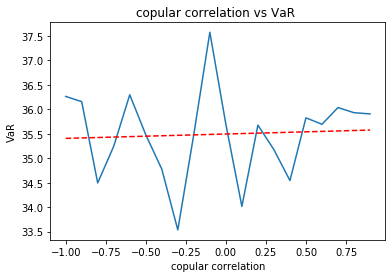

In [18]:
import pylab

# x axis values
x = lst_copular_corr
# corresponding y axis values
y = lst_index_VaR_weighted
 
# plotting the points
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('copular correlation')
# naming the y axis
plt.ylabel('VaR')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")

# giving a title to my graph
plt.title('copular correlation vs VaR ')
 
# function to show the plot
plt.show()


Discussion of results:

- In advance, VaR should be positive number. Interestingly, we have found that the correlation between AEX and FTSE has no effect on VaR. Although we can see that the midline slightly decrease, the sharpness is almost zero. 

- We have used sum function to compute the total log return. sim_cumulative_returns[i] = sum(sim_returns). If the returns are just normal return, we will use comprod function.
 